# Homework 2, *part 1* (40 points)

This warm-up problem set is provided to help you get used to PyTorch.

Please, only fill parts marked with "`Your code here`".

In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

import torch
assert torch.__version__ >= '1.0.0'

To learn best practices $-$ for example,

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use,

$-$ you are expected to google a lot, read tutorials on the Web and study documentation.

Quick documentation on functions and modules is available with `?` and `help()`, like so:

In [2]:
help(torch.sqrt)

Help on built-in function sqrt:

sqrt(...)
    sqrt(input, out=None) -> Tensor
    
    Returns a new tensor with the square-root of the elements of :attr:`input`.
    
    .. math::
        \text{out}_{i} = \sqrt{\text{input}_{i}}
    
    Args:
        input (Tensor): the input tensor
        out (Tensor, optional): the output tensor
    
    Example::
    
        >>> a = torch.randn(4)
        >>> a
        tensor([-2.0755,  1.0226,  0.0831,  0.4806])
        >>> torch.sqrt(a)
        tensor([    nan,  1.0112,  0.2883,  0.6933])



In [3]:
# to close the Jupyter help bar, press `Esc` or `q`
?torch.cat

## Task 1 (3 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

$\rho(\theta)$ is defined in polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these values.
3. Convert it into Cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [9]:
import math

theta = torch.arange(-math.pi, math.pi, 2*math.pi/1000)
assert theta.shape == (1000,)

rho = (1 + 0.9*torch.cos(8*theta))*(1+0.1*torch.cos(24*theta))*(0.9+0.05*torch.cos(200*theta))*(1+torch.sin(theta))
assert torch.is_same_size(rho, theta)

x,y = rho*torch.cos(theta), rho*torch.sin(theta)# (3) Your code here

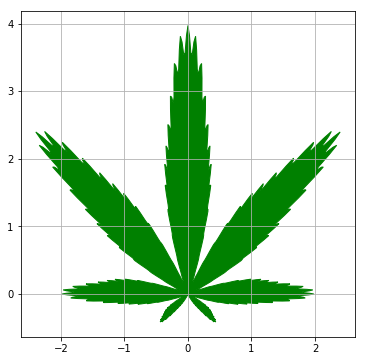

In [10]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

## Task 2 (7 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

If you skipped the URL above, here are the rules:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* At one step in time, the generation update happens:
  * Any living cell that has 2 or 3 neighbors survives, otherwise (0,1 or 4+ neighbors) it dies
  * Any cell with exactly 3 neighbors becomes alive if it was dead

You are given a reference numpy implementation of the update step. Your task is to convert it to PyTorch.

In [157]:
from scipy.signal import correlate2d as conv2d

def numpy_update(alive_map):
    # Count neighbours with convolution
    conv_kernel = np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]])
    
    num_alive_neighbors = conv2d(alive_map, conv_kernel, mode='same')
    
    # Apply game rules
    born = np.logical_and(num_alive_neighbors == 3, alive_map == 0)
    survived = np.logical_and(np.isin(num_alive_neighbors, [2,3]), alive_map == 1)
    
    np.copyto(alive_map, np.logical_or(born, survived))

In [158]:
def torch_update(alive_map):
    """
    Game of Life update function that does to `alive_map` exactly the same as `numpy_update`.
    
    :param alive_map: `torch.tensor` of shape `(height, width)` and dtype `torch.float32`
        containing 0s (dead) an 1s (alive)
    """
    # Your code here
    conv_kernel = torch.Tensor([
                            [1,1,1],
                            [1,0,1],
                            [1,1,1]
                        ])
    
    num_alive_neighbors = torch.conv2d(alive_map[None,None,], conv_kernel[None,None,], padding=1)[0][0]
    
    # Apply game rules
    born = (num_alive_neighbors == 3) & (alive_map == 0)
    survived = (num_alive_neighbors[..., None] == torch.Tensor([2,3])).any(-1) & (alive_map == 1)
    alive_map[...] = born | survived
    return alive_map

In [160]:
# Generate a random initial map
alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
alive_map_torch = torch.tensor(alive_map_numpy).float().clone()
numpy_update(alive_map_numpy)
torch_update(alive_map_torch)

# results should be identical
assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
    "Your PyTorch implementation doesn't match numpy_update."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


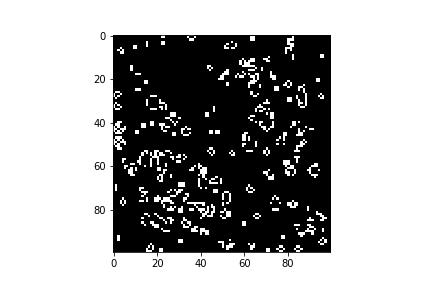

<IPython.core.display.Javascript object>


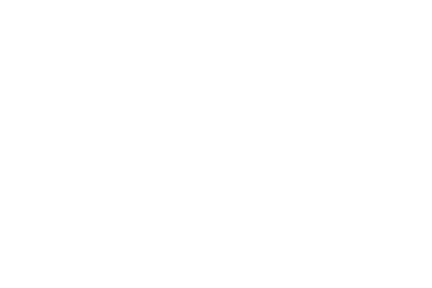

In [161]:
%matplotlib notebook
plt.ion()

# initialize game field
alive_map = np.random.choice([0, 1], size=(100, 100))
alive_map = torch.tensor(alive_map).float()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    torch_update(alive_map)
    
    # re-draw image
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>


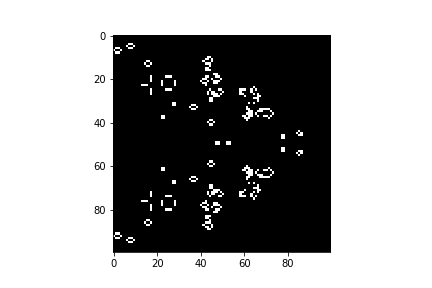

<IPython.core.display.Javascript object>


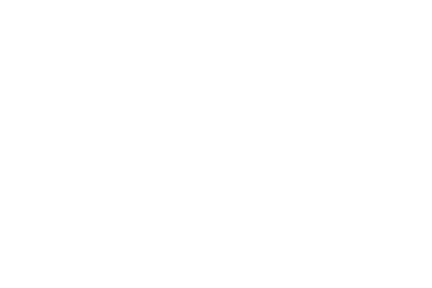

In [162]:
# A fun setup for your amusement
alive_map = np.arange(100) % 2 + np.zeros([100, 100])
alive_map[48:52, 50] = 1

alive_map = torch.tensor(alive_map).float()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(150):
    torch_update(alive_map)
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

## Task 3 (30 points)

You have to solve yet another character recognition problem: 10 letters, ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% accuracy
2. at least 2 linear layers
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

**You are NOT allowed to use**
* numpy arrays
* `torch.nn`, `torch.optim`
* convolutions

Tips:

* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

**Reproducibility requirement**: you have to format your code cells so that `Cell -> Run All` on a fresh notebook **reliably** trains your model to the desired accuracy in a couple of minutes and reports the accuracy reached.

Happy googling!

# Let's transfer our mistakes and suffering from the last homework =)

In [513]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box) 
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`: 
        
        output = module.forward(input)
    
    The module should be able to perform a backward pass: to differentiate the `forward` function. 
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule. 
    
        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.training = True
    
    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.
        
        Make sure to both store the data in `output` field and return it. 
        """
        
        # The easiest case:
            
        # self.output = input 
        # return self.output
        
        pass
    
    def zeroGradParameters(self): 
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass
        
    def getParameters(self):
        """
        Returns a list with its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
        
    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
    
    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True
    
    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False
    
    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Module"

In [514]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially. 
         
         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`. 
    """
    
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:
        
            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})   
            
            
        Just write a little loop. 
        """

        # Your code goes here. ################################################
        current_input = input
        
        for m in self.modules:
            current_input = m.forward(current_input)
            
        self.output = current_input
            
        return self.output

    def zeroGradParameters(self): 
        for module in self.modules:
            module.zeroGradParameters()
    
    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]
    
    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)
    
    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()
    
    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

In [515]:
import math
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
        
        # This is a nice initialization
        distribution = torch.distributions.normal.Normal(loc=0.0, scale=1./math.sqrt(n_in))
        self.W = torch.tensor(distribution.sample(torch.Size([n_out,n_in])),requires_grad=True)
        self.b = torch.tensor(distribution.sample(torch.Size([n_out])),requires_grad=True)
        
    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = torch.add(self.W @ input.transpose(0,1), self.b[:,None]).transpose(0,1) # dim check (out.in x in.ns + out)^T = ns.out
        return self.output
    
    def zeroGradParameters(self):
        if self.W.grad is not None:
            self.W.grad.data.zero_()
        if self.b.grad is not None:
            self.b.grad.data.zero_()
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.W.grad, self.b.grad]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [516]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = input - input.max(dim=-1)[0][...,None].expand_as(input)
        e = torch.exp(self.output)
        self.output = torch.div(e, torch.sum(torch.exp(self.output), dim=-1)[...,None].expand_as(e))
        return self.output
    
    def __repr__(self):
        return "SoftMax"

In [517]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, input):
        self.output = torch.max(input, torch.tensor(0.0))
        return self.output
    
    def __repr__(self):
        return "ReLU"

In [546]:
# requires one hot encoded labels!!!
def co_loss(probs, labels):
    return -torch.sum(torch.mul(probs, labels))/probs.shape[0]

In [541]:
def sgd_momentum(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    with torch.no_grad():
        state.setdefault('accumulated_grads', {})

        var_index = 0 
        for current_layer_vars, current_layer_grads in zip(variables, gradients): 
            for current_var, current_grad in zip(current_layer_vars, current_layer_grads):

                old_grad = state['accumulated_grads'].setdefault(var_index, torch.zeros_like(current_grad))

                old_grad[...] = torch.add(config['momentum'] * old_grad, config['learning_rate'] * current_grad)

                current_var -= old_grad
                var_index += 1     

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [566]:
def accuracy(model, images, labels):
    """
    model: `NeuralNet`
    images: `torch.tensor` of shape `N x height x width`
        and dtype `torch.float32`
    labels: `torch.tensor` of shape `N` and dtype `torch.int64`. Contains
        class index for each sample
    
    returns:
        fraction of samples from `images` correctly classified by `model`
    """
    # Your code here
    model.evaluate()
    return torch.mean(torch.eq(torch.argmax(model.forward(images), dim=1), labels).float())

# Let's first check on the toy example from the first homework

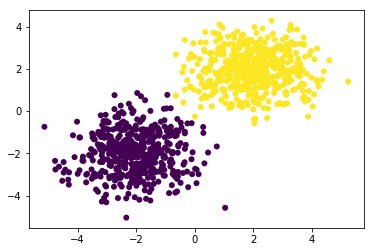

In [543]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

In [544]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = torch.randperm(n_samples)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield torch.Tensor(X[batch_idx]), torch.Tensor(Y[batch_idx])

In [545]:

#model = NeuralNet()

# Your code here (train the model)

net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

/home/dmitriy/MyEnv/other/skoltech/dl/env/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/dmitriy/MyEnv/other/skoltech/dl/env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


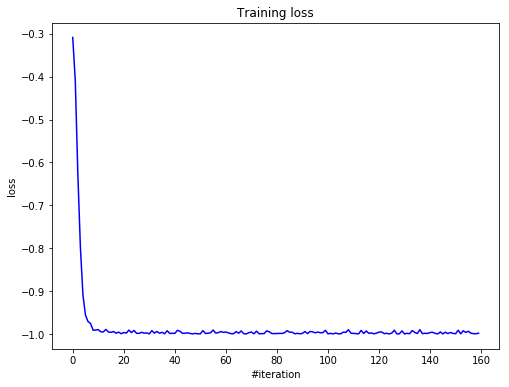

Current loss: -0.998089


In [548]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = co_loss(predictions, y_batch)
    
        # Backward
        loss.backward()
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss) 

### Seems to be fine

In [549]:
np.random.seed(666)
torch.manual_seed(666)

from notmnist import load_notmnist
letters = 'ABCDEFGHIJ' 
X_train, y_train, X_test, y_test = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_test.squeeze_();

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]


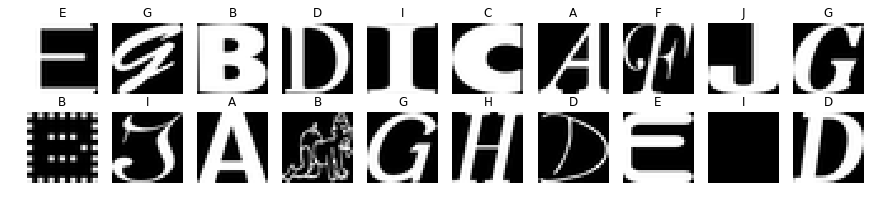

In [550]:
fig, axarr = plt.subplots(2, 10, figsize=(15,3))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx].numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

#### one hot encode data

In [551]:
y_train_oho = torch.zeros(y_train.size()[0], len(letters)).scatter_(1, y_train.view(-1, 1), 1)
y_test_oho = torch.zeros(y_test.size()[0], len(letters)).scatter_(1, y_test.view(-1, 1), 1)

In [552]:
X_train_oho = X_train.view([-1, X_train.shape[1]*X_train.shape[2]])
X_test_oho = X_test.view([-1, X_test.shape[1]*X_test.shape[2]])

#### define the network etc

In [553]:
net = Sequential()
net.add(Linear(X_train_oho.shape[1], 100))
net.add(ReLU())        
net.add(Linear(100, y_train_oho.shape[1]))
net.add(SoftMax())

# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

/home/dmitriy/MyEnv/other/skoltech/dl/env/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/dmitriy/MyEnv/other/skoltech/dl/env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


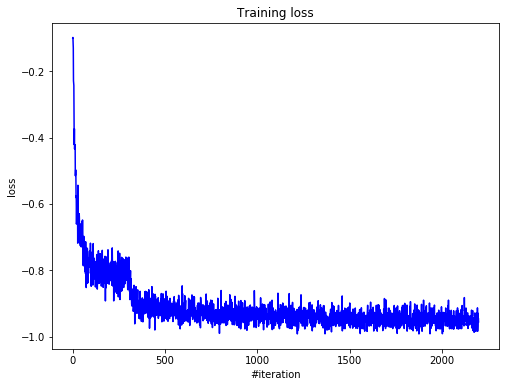

Current loss: -0.955447


In [554]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train_oho, y_train_oho), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = co_loss(predictions, y_batch)
    
        # Backward
        loss.backward()
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss) 

In [567]:
model = net
train_acc = accuracy(model, X_train_oho, y_train) * 100
test_acc = accuracy(model, X_test_oho, y_test) * 100
print("Train accuracy: %.2f, test accuracy: %.2f" % (train_acc, test_acc))

assert test_acc >= 82.0, "You have to do better"

Train accuracy: 94.99, test accuracy: 90.84
